In [229]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# .ensemble 메서드는 앙상블 학습 위주
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import(
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split # .model_seclection 메서드는 모델의 성능 평가와 하이퍼파라미터튜닝
from tqdm import tqdm # 진행바 표시 라이브러리

## 데이터 로드

In [230]:
# 전처리 완료된 데이터
train = pd.read_csv(r'C:\Users\njh45\OneDrive\바탕 화면\preprocessing_data.csv', encoding='utf-8-sig')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3316 entries, 0 to 3315
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   isbn                 3316 non-null   int64  
 1   title                3316 non-null   object 
 2   publishDate          3316 non-null   int64  
 3   price                3316 non-null   int64  
 4   pageCount            3316 non-null   int64  
 5   size                 3316 non-null   float64
 6   weight               3316 non-null   int64  
 7   rating               3316 non-null   float64
 8   shortReviewCount     3316 non-null   float64
 9   fullReviewCount      3316 non-null   float64
 10  label                3316 non-null   int64  
 11  shortReview_present  3316 non-null   int64  
 12  fullReview_present   3316 non-null   int64  
 13  author_name_tf       3316 non-null   int64  
 14  publisher_name_tf    3316 non-null   int64  
dtypes: float64(4), int64(10), object(1)
me

In [231]:
# 알라딘 주관적 해석이 들어간 피처 제외

train.drop(columns=[
    'rating',
    'shortReviewCount',
    'fullReviewCount',
    'shortReview_present',
    'fullReview_present'
], inplace=True)

In [232]:
# lda 결과들
best_lda = pd.read_csv(r'C:\Users\njh45\OneDrive\바탕 화면\best_lda.csv', encoding='utf-8-sig')
best_lda.info()

book_lda = pd.read_csv(r'C:\Users\njh45\OneDrive\바탕 화면\book_lda.csv', encoding='utf-8-sig')
book_lda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   topic_0  1000 non-null   float64
 1   topic_1  1000 non-null   float64
 2   topic_2  1000 non-null   float64
 3   topic_3  1000 non-null   float64
 4   topic_4  1000 non-null   float64
 5   topic_5  1000 non-null   float64
 6   isbn     1000 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 54.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   topic_0  627 non-null    float64
 1   topic_1  627 non-null    float64
 2   topic_2  627 non-null    float64
 3   topic_3  627 non-null    float64
 4   topic_4  627 non-null    float64
 5   topic_5  627 non-null    float64
 6   isbn     627 non-null    int64  
dtypes: float64(6), int64(1)
memory usage: 34.4 KB


In [233]:
# 1. 고유 isbn 값 집합으로 추출
isbn_book = set(book_lda['isbn'].unique())
isbn_best = set(best_lda['isbn'].unique())

# 2. 겹치는 isbn 값
common_isbn = isbn_book.intersection(isbn_best)

# 3. 개수 확인
print(f"book_lda의 고유 isbn 수: {len(isbn_book)}")
print(f"best_lda의 고유 isbn 수: {len(isbn_best)}")
print(f"공통된 isbn 수: {len(common_isbn)}")

# 4. 필요하면 실제 겹치는 isbn 값 출력
# print(common_isbn)

book_lda의 고유 isbn 수: 627
best_lda의 고유 isbn 수: 1000
공통된 isbn 수: 0


## 3개 데이터프레임 concat

In [234]:
# 0. 먼저 train에 best_lda 병합
train = train.merge(best_lda, on='isbn', how='left')

In [235]:
# 1. book_lda를 train에 병합 (접미사 _book 붙이기)
train = train.merge(book_lda, on='isbn', how='left', suffixes=('', '_book'))

# 2. topic_i 결측치만 book_lda의 값으로 채우고, _book 컬럼은 제거
for i in range(6):
    topic_col = f'topic_{i}'
    topic_book_col = f'{topic_col}_book'

    if topic_book_col in train.columns:
        train[topic_col] = train[topic_col].fillna(train[topic_book_col])
        train.drop(columns=[topic_book_col], inplace=True)

In [236]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3316 entries, 0 to 3315
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   isbn               3316 non-null   int64  
 1   title              3316 non-null   object 
 2   publishDate        3316 non-null   int64  
 3   price              3316 non-null   int64  
 4   pageCount          3316 non-null   int64  
 5   size               3316 non-null   float64
 6   weight             3316 non-null   int64  
 7   label              3316 non-null   int64  
 8   author_name_tf     3316 non-null   int64  
 9   publisher_name_tf  3316 non-null   int64  
 10  topic_0            1627 non-null   float64
 11  topic_1            1627 non-null   float64
 12  topic_2            1627 non-null   float64
 13  topic_3            1627 non-null   float64
 14  topic_4            1627 non-null   float64
 15  topic_5            1627 non-null   float64
dtypes: float64(7), int64(8),

In [237]:
train[train['topic_0'].notna()]['label'].value_counts()

label
1    1000
0     627
Name: count, dtype: int64

In [238]:
print(train['label'].value_counts())

label
0    2316
1    1000
Name: count, dtype: int64


## lgbm

In [12]:
import lightgbm
print(lightgbm.__version__)

4.6.0


### [항상 실행 X] 3316개 중 토픽 벡터를 적절히 반영해서 val 만들때만 사용

In [51]:
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# topic_0이 0이 아닌 데이터만 필터링
subset = train[train['topic_0'].notna()]

# topic_0 ≠ 0인 데이터 중에서 label 비율 유지하며 720개 추출
val_set, _ = train_test_split(
    subset,
    test_size=(len(subset) - 720),
    stratify=subset['label'],
    random_state=42
)

# 1. 검증셋
X_valid = val_set.drop(columns=['label', 'isbn', 'title'])
y_valid = val_set['label']

# 2. 학습셋: val_set에 포함되지 않은 데이터만 사용
train_set = train.drop(index=val_set.index)
X_train = train_set.drop(columns=['label', 'isbn', 'title'])
y_train = train_set['label']

### [항상 실행 X] 하이퍼 파라미터 튜닝

### 실제 학습 시작

In [239]:
train = train[train['topic_0'].notna()]

In [240]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1627 entries, 8 to 3315
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   isbn               1627 non-null   int64  
 1   title              1627 non-null   object 
 2   publishDate        1627 non-null   int64  
 3   price              1627 non-null   int64  
 4   pageCount          1627 non-null   int64  
 5   size               1627 non-null   float64
 6   weight             1627 non-null   int64  
 7   label              1627 non-null   int64  
 8   author_name_tf     1627 non-null   int64  
 9   publisher_name_tf  1627 non-null   int64  
 10  topic_0            1627 non-null   float64
 11  topic_1            1627 non-null   float64
 12  topic_2            1627 non-null   float64
 13  topic_3            1627 non-null   float64
 14  topic_4            1627 non-null   float64
 15  topic_5            1627 non-null   float64
dtypes: float64(7), int64(8), obje

In [241]:
book_entropy = pd.read_csv(r'C:\Users\njh45\OneDrive\바탕 화면\book_entropy.csv', encoding='utf-8-sig')
best_entropy = pd.read_csv(r'C:\Users\njh45\OneDrive\바탕 화면\best_entropy.csv', encoding='utf-8-sig')

In [242]:
book_entropy.drop(columns=[
    'topic_0',
    'topic_1',
    'topic_2',
    'topic_3',
    'topic_4',
    'topic_5'
], inplace=True)

best_entropy.drop(columns=[
    'topic_0',
    'topic_1',
    'topic_2',
    'topic_3',
    'topic_4',
    'topic_5'
], inplace=True)

In [243]:
book_entropy.info()
best_entropy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   isbn     627 non-null    int64  
 1   entropy  627 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 9.9 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   isbn     1000 non-null   int64  
 1   entropy  1000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 15.8 KB


In [244]:
# 1. 두 entropy df를 하나로 합치기
total_entropy = pd.concat([book_entropy, best_entropy], ignore_index=True)

# 2. 중복 isbn 제거 (혹시라도 겹칠 경우 최신값 유지)
total_entropy = total_entropy.drop_duplicates(subset='isbn', keep='last')

# 3. train과 병합
train = train.merge(total_entropy, on='isbn', how='left')

# 확인
print(train['entropy'].isna().sum())  # 0이면 성공

0


In [245]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1627 entries, 0 to 1626
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   isbn               1627 non-null   int64  
 1   title              1627 non-null   object 
 2   publishDate        1627 non-null   int64  
 3   price              1627 non-null   int64  
 4   pageCount          1627 non-null   int64  
 5   size               1627 non-null   float64
 6   weight             1627 non-null   int64  
 7   label              1627 non-null   int64  
 8   author_name_tf     1627 non-null   int64  
 9   publisher_name_tf  1627 non-null   int64  
 10  topic_0            1627 non-null   float64
 11  topic_1            1627 non-null   float64
 12  topic_2            1627 non-null   float64
 13  topic_3            1627 non-null   float64
 14  topic_4            1627 non-null   float64
 15  topic_5            1627 non-null   float64
 16  entropy            1627 

In [246]:
train2 = train.copy()

In [247]:
import numpy as np

topic_cols = [f'topic_{i}' for i in range(6)]
for col in topic_cols:
    train[col] = np.exp(train[col])

In [248]:
import numpy as np

# 1. 로그 변환 (log1p 사용: log(1 + x) → 0일 때도 안정적)
train['entropy'] = (1 - np.log1p(train['entropy']))

# 2. topic_0 ~ topic_5에 entropy 곱하기
topic_cols = [f'topic_{i}' for i in range(6)]
for col in topic_cols:
    train[col] = train[col] * train['entropy']

In [249]:
train.drop(columns=['entropy'], inplace=True)

In [265]:
train['size_log'] = np.log1p(train['size'])

[LightGBM] [Info] Number of positive: 750, number of negative: 470
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2519
[LightGBM] [Info] Number of data points in the train set: 1220, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.614754 -> initscore=0.467341
[LightGBM] [Info] Start training from score 0.467341
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[40]	train's binary_logloss: 0.0657063	val's binary_logloss: 0.202108
Accuracy:  0.9262
Recall:    0.9350
Precision: 0.9444
F1 Score:  0.9397


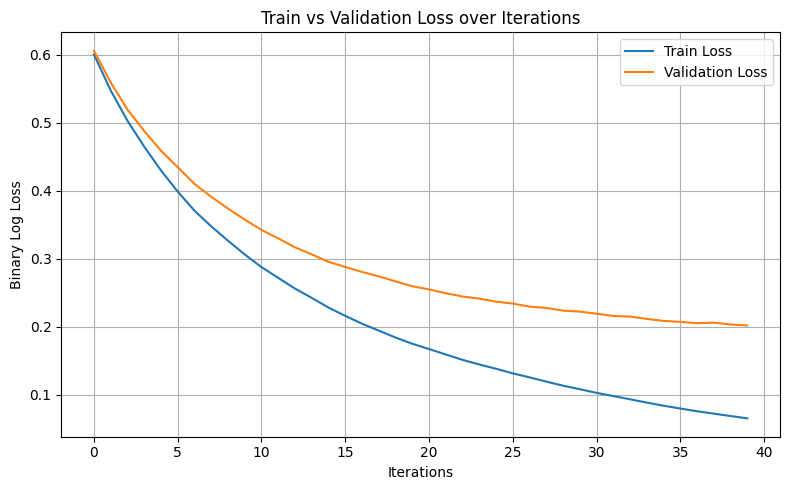

In [266]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
import matplotlib.pyplot as plt
from lightgbm import record_evaluation

evals_result = {}

# X, y 정의
drop_cols = ['isbn', 'title']
X = train.drop(columns=drop_cols + ['label'])
y = train['label']

# 먼저 train_temp:val+test = 7.5:2.5 분할
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# val:test = 4:1
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

# 모델 정의
model = LGBMClassifier(
    random_state=42,
    n_estimators=40
)

# 학습 (callbacks만 사용)
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_names=['train', 'val'],
    eval_metric='binary_logloss',
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=50),
        record_evaluation(evals_result)
    ]
)

# 예측
y_pred = model.predict(X_val)

# 성능 지표 출력
print(f"Accuracy:  {accuracy_score(y_val, y_pred):.4f}")
print(f"Recall:    {recall_score(y_val, y_pred):.4f}")
print(f"Precision: {precision_score(y_val, y_pred):.4f}")
print(f"F1 Score:  {f1_score(y_val, y_pred):.4f}")

# 손실 시각화
plt.figure(figsize=(8, 5))
plt.plot(evals_result['train']['binary_logloss'], label='Train Loss')
plt.plot(evals_result['val']['binary_logloss'], label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Binary Log Loss')
plt.title('Train vs Validation Loss over Iterations')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

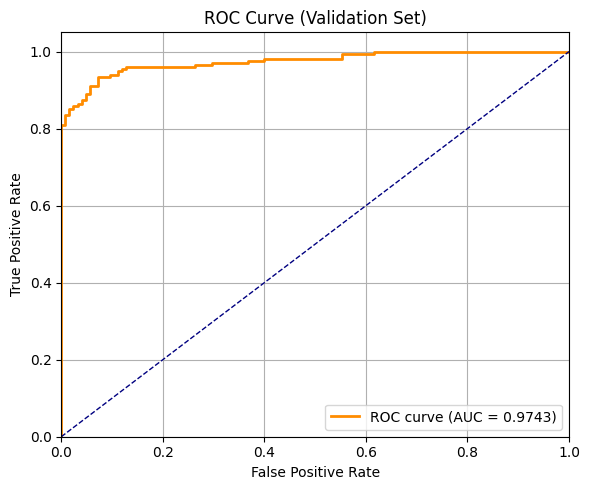

In [268]:
from sklearn.metrics import roc_curve, auc

# 예측 확률 (양성 클래스에 대한 확률만)
y_prob = model.predict_proba(X_val)[:, 1]

# FPR, TPR 계산
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

# 시각화
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')  # 대각선 (랜덤 분류기 기준)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Validation Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

### 시각화

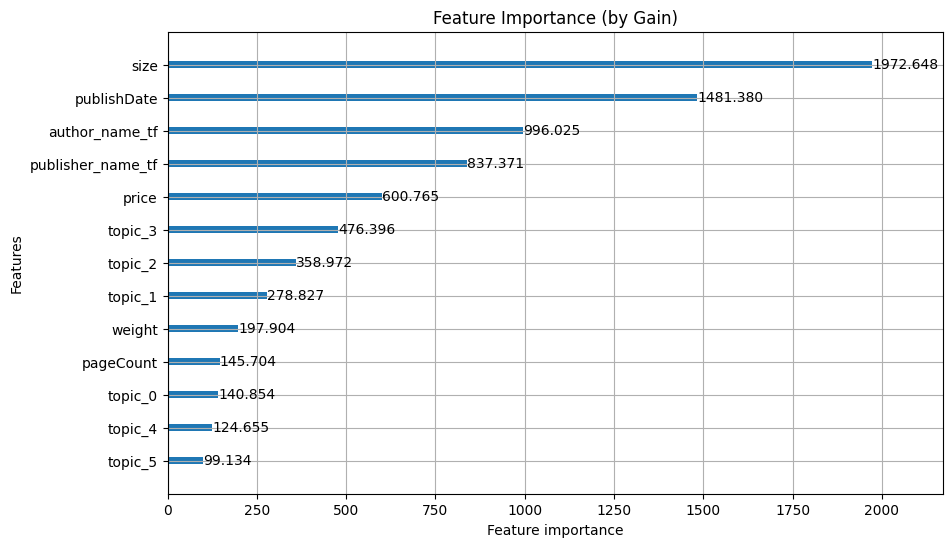

In [263]:
import matplotlib.pyplot as plt
import lightgbm as lgb

# 피처 중요도 출력
lgb.plot_importance(model, max_num_features=20, importance_type='gain', figsize=(10, 6))
plt.title("Feature Importance (by Gain)")
plt.show()

C:\Users\njh45\AppData\Roaming\Python\Python312\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


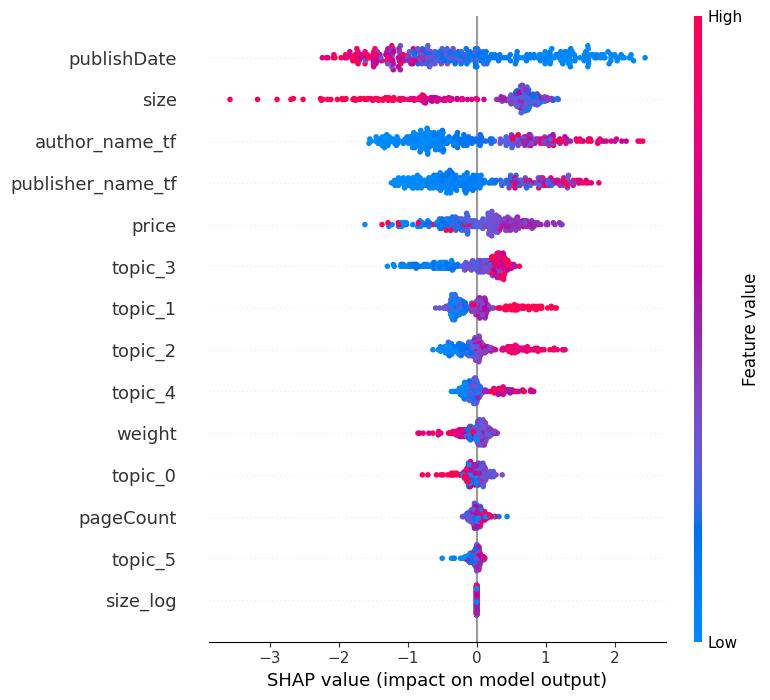

In [267]:
import shap
import matplotlib.pyplot as plt

# TreeExplainer 객체 생성
explainer = shap.TreeExplainer(model)

# SHAP 값 계산 (X_val은 반드시 X_train과 같은 컬럼 구조여야 함)
X_val_fixed = X_val.reindex(columns=X_train.columns)  # 열 순서/개수 맞추기
shap_values = explainer.shap_values(X_val_fixed)

# 요약 플롯 - dot plot
shap.summary_plot(shap_values, X_val_fixed, plot_type="dot")

## [통계] publishDate, size, author_name_tf

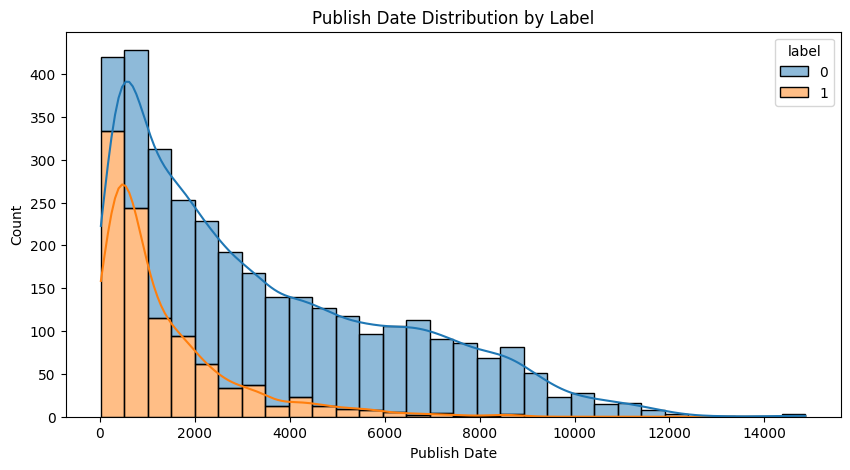

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# label에 따른 publishDate 분포 비교
plt.figure(figsize=(10, 5))
sns.histplot(data=train, x='publishDate', hue='label', bins=30, kde=True, multiple="stack")
plt.title('Publish Date Distribution by Label')
plt.xlabel('Publish Date')
plt.ylabel('Count')
plt.show()


## 1000권의 베스트셀러는 차트인이 최소 22 ~ 64주 = 4.4 ~ 12.8달 = 134 ~ 390일
## 총 수집 기간은 13개월 = 396.5일

## 1000일 이전에 출간된 책이 전체 베스트 셀러의 약 60% 정도를 차지하는 것을 볼 수 있음
## 총 수집 기간보다 훨씬 이전에 나온 책들이 약 60% 정도를 차지하고 있으므로 수집 기간 동안
## 토픽 모델링 결과는 1000일 정도까지의 소설/시/희곡의 트렌드를 약 60%정도 포함

C:\Users\njh45\AppData\Local\Temp\ipykernel_28216\3705951837.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Label')


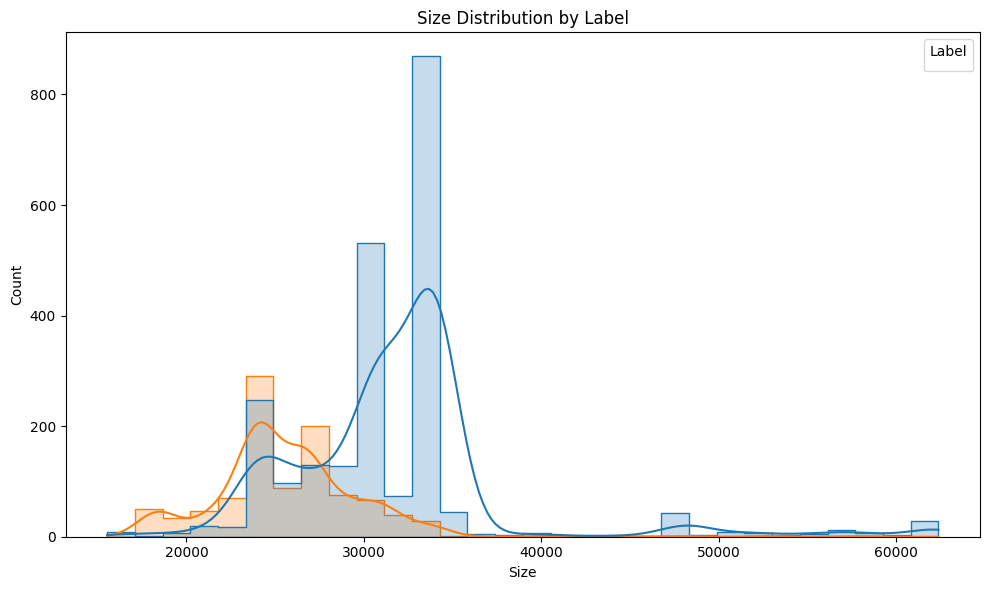

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(data=train, x='size', hue='label', bins=30, kde=True, element='step')
plt.title("Size Distribution by Label")
plt.xlabel("Size")
plt.ylabel("Count")
plt.legend(title='Label')
plt.tight_layout()
plt.show()

In [ ]:
# 딱봐도 정규분포 아니고 검사 해봐도 아님

# 맨 휘트니 검정
from scipy.stats import mannwhitneyu

group0 = train[train['label'] == 0]['size']
group1 = train[train['label'] == 1]['size']

u_stat, p_value = mannwhitneyu(group1, group0, alternative='less')  # label=1이 더 작다
print(f'U-statistic: {u_stat}, p-value: {p_value}')

## H0 : H1이 아니다 / H1 : label=1의 분포가 더 작다
## p-value가 0에 가까움 H1이 참

U-statistic: 387782.0, p-value: 1.8302664601129054e-206


C:\Users\njh45\AppData\Local\Temp\ipykernel_28216\2237152081.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Label')


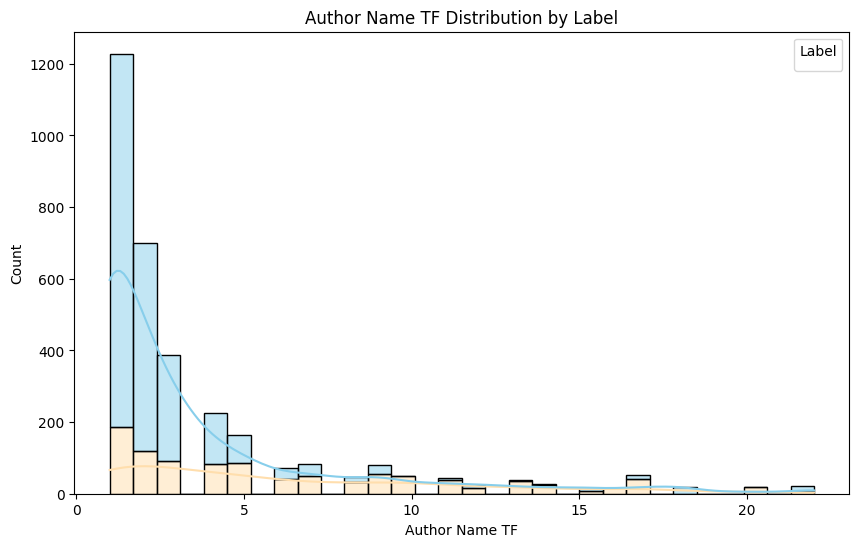

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(
    data=train,
    x='author_name_tf',
    hue='label',
    bins=30,
    kde=True,
    palette={0: 'skyblue', 1: 'navajowhite'},
    multiple='stack'
)
plt.title('Author Name TF Distribution by Label')
plt.xlabel('Author Name TF')
plt.ylabel('Count')
plt.legend(title='Label')
plt.show()


In [ ]:
# TF가 5 이하인 일반도서(label=0)
low_tf_count = train[(train['label'] == 0) & (train['author_name_tf'] <= 5)].shape[0]

# TF가 6 이상인 일반도서(label=0)
high_tf_count = train[(train['label'] == 0) & (train['author_name_tf'] > 5)].shape[0]

print(f"TF ≤ 5인 일반도서 수: {low_tf_count}")
print(f"TF > 5인 일반도서 수: {high_tf_count}")

k = high_tf_count / low_tf_count * 100
print(f"5이하인 일반도서 비율 : {k}")

## 별 유의미한 사항은 아닌데 보통 책을 5권 이하로만 출간하고
## 6권 이상 출간하게 된다면 높은 확률로 베스트 셀러가 될 수 있음을 확인할 수 있다. 필요하면 수치를 뽑겠음

TF ≤ 5인 일반도서 수: 2137
TF > 5인 일반도서 수: 179
5이하인 일반도서 비율 : 8.376228357510529


## subset

In [69]:
train2 = train[train['topic_0'].notna()].copy()

In [70]:
train2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1627 entries, 8 to 3315
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   isbn               1627 non-null   int64  
 1   title              1627 non-null   object 
 2   publishDate        1627 non-null   int64  
 3   price              1627 non-null   int64  
 4   pageCount          1627 non-null   int64  
 5   size               1627 non-null   float64
 6   weight             1627 non-null   int64  
 7   label              1627 non-null   int64  
 8   author_name_tf     1627 non-null   int64  
 9   publisher_name_tf  1627 non-null   int64  
 10  topic_0            1627 non-null   float64
 11  topic_1            1627 non-null   float64
 12  topic_2            1627 non-null   float64
 13  topic_3            1627 non-null   float64
 14  topic_4            1627 non-null   float64
 15  topic_5            1627 non-null   float64
dtypes: float64(7), int64(8), obje

[LightGBM] [Info] Number of positive: 800, number of negative: 501
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1928
[LightGBM] [Info] Number of data points in the train set: 1301, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.614912 -> initscore=0.468006
[LightGBM] [Info] Start training from score 0.468006
Training until validation scores don't improve for 30 rounds
[50]	valid_0's binary_logloss: 0.48729
Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.462647
Confusion Matrix:
[[ 83  43]
 [ 28 172]]

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.66      0.70       126
           1       0.80      0.86      0.83       200

    accuracy                           0.78       326
   macro avg       0.77      0.76      0.76       326
we

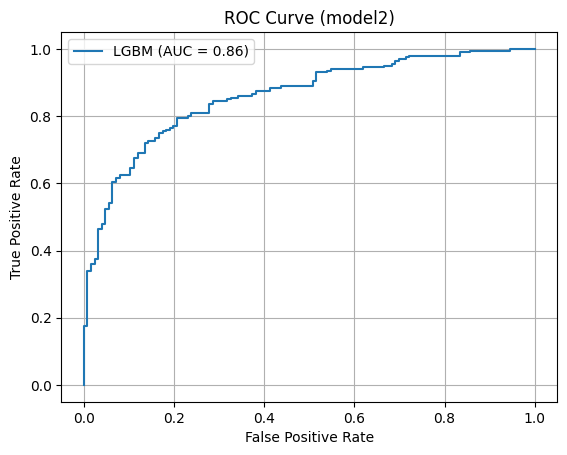

C:\Users\njh45\AppData\Roaming\Python\Python312\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


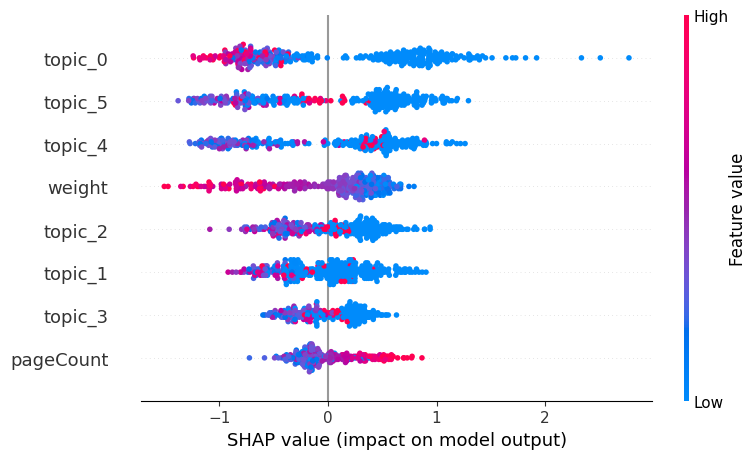

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
import matplotlib.pyplot as plt
import shap

# 1. X, y 정의
drop_cols = ['isbn', 'title', 'publishDate', 'author_name_tf', 'publisher_name_tf', 'size', 'price']
X2 = train2.drop(columns=drop_cols + ['label'])
y2 = train2['label']

# 2. train/validation split (8:2)
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(
    X2, y2, test_size=0.2, random_state=42, stratify=y2
)

# 3. LGBM 모델 정의
model2 = LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    random_state=42,
    n_estimators=1000
)

# 4. 모델 학습
model2.fit(
    X_train2, y_train2,
    eval_set=[(X_valid2, y_valid2)],
    eval_metric='binary_logloss',
    callbacks=[
        early_stopping(stopping_rounds=30),
        log_evaluation(period=50)
    ]
)

# 5. 예측
y_pred2 = model2.predict(X_valid2)
y_prob2 = model2.predict_proba(X_valid2)[:, 1]

# 6. 평가 지표 출력
print("Confusion Matrix:")
print(confusion_matrix(y_valid2, y_pred2))
print("\nClassification Report:")
print(classification_report(y_valid2, y_pred2))

print("Accuracy:", accuracy_score(y_valid2, y_pred2))
print("Precision:", precision_score(y_valid2, y_pred2))
print("Recall:", recall_score(y_valid2, y_pred2))
print("F1-score:", f1_score(y_valid2, y_pred2))
print("ROC-AUC:", roc_auc_score(y_valid2, y_prob2))

# 7. ROC Curve 시각화
fpr, tpr, thresholds = roc_curve(y_valid2, y_prob2)
plt.plot(fpr, tpr, label='LGBM (AUC = {:.2f})'.format(roc_auc_score(y_valid2, y_prob2)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (model2)')
plt.legend()
plt.grid()
plt.show()

# 8. SHAP 분석
explainer2 = shap.TreeExplainer(model2)
shap_values2 = explainer2.shap_values(X_valid2)

# SHAP Summary Plot
shap.summary_plot(shap_values2, X_valid2)
